<a href="https://colab.research.google.com/github/Aliiiqbp/Self-Study/blob/main/LLM%20Serving/Efficiently_Serving_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Generation and KV-Cache

imports and model load


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

### next token generation

In [ ]:
prompt = "The black bear ran into the"
inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[ 464, 2042, 6842, 4966,  656,  262]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
print(logits.shape)

torch.Size([1, 6, 50257])


In [ ]:
last_logits = logits[0, -1, :]
next_token_id = last_logits.argmax()
next_token_id

tensor(16479)

In [ ]:
tokenizer.decode(next_token_id)

' woods'

In [ ]:
top_k = torch.topk(last_logits, k=10)
tokens = [tokenizer.decode(tk) for tk in top_k.indices]
tokens

[' woods',
 ' crowd',
 ' house',
 ' forest',
 ' back',
 ' bushes',
 ' street',
 ' water',
 ' parking',
 ' room']

In [ ]:
next_inputs = {
    "input_ids": torch.cat(
        [inputs["input_ids"], next_token_id.reshape((1, 1))],
        dim=1
    ),
    "attention_mask": torch.cat(
        [inputs["attention_mask"], torch.tensor([[1]])],
        dim=1
    ),
}


print(next_inputs["input_ids"],
      next_inputs["input_ids"].shape)
print(next_inputs["attention_mask"],
      next_inputs["attention_mask"].shape)

tensor([[  464,  2042,  6842,  4966,   656,   262, 16479]]) torch.Size([1, 7])
tensor([[1, 1, 1, 1, 1, 1, 1]]) torch.Size([1, 7])


### autoregressive tokens generation

In [ ]:
def generate_token(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id

In [ ]:
generated_tokens = []
next_inputs = inputs
durations_s = []
for _ in range(20):
    t0 = time.time()
    next_token_id = generate_token(next_inputs)
    durations_s += [time.time() - t0]

    next_inputs = {
        # input id concatenate the last generated token with the input to create the next round input
        "input_ids": torch.cat(
            [next_inputs["input_ids"], next_token_id.reshape((1, 1))],
            dim=1),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_s)} s")
print(generated_tokens)

7.076610088348389 s
[' woods', ' and', ' was', ' chased', ' by', ' a', ' group', ' of', ' white', ' bears', '.', '\n', '\n', 'The', ' bear', ' was', ' eventually', ' caught', ' and', ' taken']


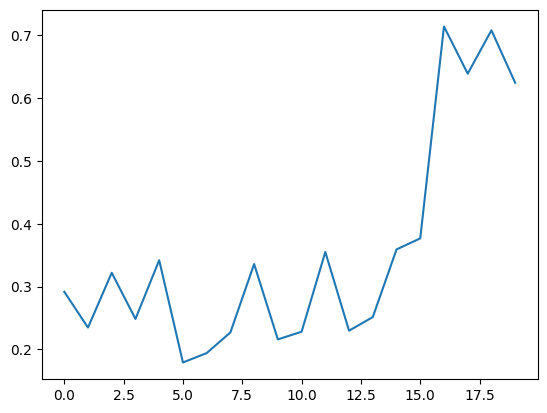

In [ ]:
plt.plot(durations_s)
plt.show()

### kv-cache to speed-up the token generation

In [ ]:
def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values

In [ ]:
generated_tokens = []
next_inputs = inputs
durations_cached_s = []
for _ in range(20):
    t0 = time.time()
    next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
    durations_cached_s += [time.time() - t0]

    next_inputs = {
        # input id only keep the last token, and not the whole concatenated tokens on top of input
        "input_ids": next_token_id.reshape((1, 1)),
        "attention_mask": torch.cat(
            [next_inputs["attention_mask"], torch.tensor([[1]])],
            dim=1),
        "past_key_values": past_key_values,
    }

    next_token = tokenizer.decode(next_token_id)
    generated_tokens.append(next_token)

print(f"{sum(durations_cached_s)} s")
print(generated_tokens)

2.8880457878112793 s
[' woods', ' and', ' was', ' chased', ' by', ' a', ' group', ' of', ' white', ' bears', '.', '\n', '\n', 'The', ' bear', ' was', ' eventually', ' caught', ' and', ' taken']


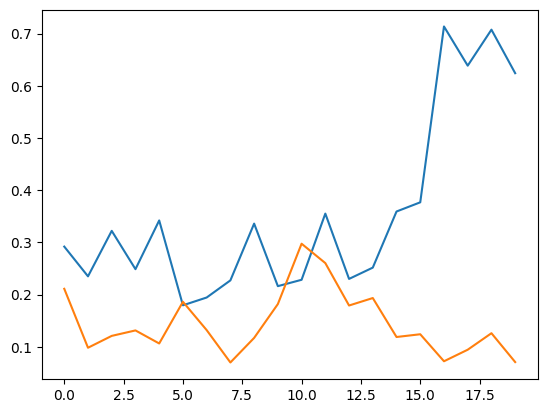

In [ ]:
plt.plot(durations_s)
plt.plot(durations_cached_s)
plt.show()

# Batching

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from tqdm import tqdm

In [ ]:
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
prompt = "The quick brown fox jumped over the"
inputs = tokenizer(prompt, return_tensors="pt")


def generate_token_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[0, -1, :]
    next_token_id = last_logits.argmax()
    return next_token_id, outputs.past_key_values


def generate(inputs, max_tokens):
    generated_tokens = []
    next_inputs = inputs
    for _ in range(max_tokens):
        next_token_id, past_key_values = \
        generate_token_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_id.reshape((1, 1)),
            "attention_mask": torch.cat(
                [next_inputs["attention_mask"], torch.tensor([[1]])],
                dim=1
            ),
            "past_key_values": past_key_values,
        }

        next_token = tokenizer.decode(next_token_id)
        generated_tokens.append(next_token)
    return "".join(generated_tokens)


tokens = generate(inputs, max_tokens=10)
print(tokens)

 fence and ran to the other side of the fence


### padding and batching matrices

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [ ]:
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [ ]:
print("input_ids:", inputs["input_ids"])
print("shape:", inputs["input_ids"].shape)

print("attention_mask:", inputs["attention_mask"])
print("shape:", inputs["attention_mask"].shape)

### in attention mask, we have 0's for padding tokens and 1's for the actual tokens.

input_ids: tensor([[  464,  2068,  7586, 21831, 11687,   625,   262],
        [50256, 50256,   464,  6290,   287,  8602,  8953],
        [50256, 50256, 50256,  2061,  2058,   510,  1276]])
shape: torch.Size([3, 7])
attention_mask: tensor([[1, 1, 1, 1, 1, 1, 1],
        [0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 1, 1, 1, 1]])
shape: torch.Size([3, 7])


In [ ]:
### positions are described in increasing integers sequence. 1's means padding tokens
### the first 0 means the begining of the actual tokens and prompts and gradually would
### increased by 1 at each index to give the model a sense of token's positions

attention_mask = inputs["attention_mask"]
position_ids = attention_mask.long().cumsum(-1) - 1
position_ids.masked_fill_(attention_mask == 0, 1)

tensor([[0, 1, 2, 3, 4, 5, 6],
        [1, 1, 0, 1, 2, 3, 4],
        [1, 1, 1, 0, 1, 2, 3]])

In [ ]:
# same as before, but include the position_ids
with torch.no_grad():
    outputs = model(position_ids=position_ids, **inputs)
logits = outputs.logits

'''
previously, we only got argmax of logits for the first element in the batch
now, we are doing it over the batch dimension to get the argmax for each element
basically, we are getting the max logits for each prompt in the batch
last_logits = logits[0:, -1, :]
'''
last_logits = logits[:, -1, :]
next_token_ids = last_logits.argmax(dim=1)
print(next_token_ids)

next_tokens = tokenizer.batch_decode(next_token_ids)
next_tokens

for i in range(len(prompts)):
    print('batch', i, ':', prompts[i], "##### NEXT TOKEN:", next_tokens[i])

tensor([13990,   319,   307])
batch 0 : The quick brown fox jumped over the ##### NEXT TOKEN:  fence
batch 1 : The rain in Spain falls ##### NEXT TOKEN:  on
batch 2 : What comes up must ##### NEXT TOKEN:  be


### generating multiple token for each prompt in the batch

In [ ]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [
        [] for _ in range(inputs["input_ids"].shape[0])
    ]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }

    for _ in range(max_tokens):
        next_token_ids, past_key_values = \
            generate_batch_tokens_with_past(next_inputs)

        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [ ]:
generated_tokens = generate_batch(inputs, max_tokens=10)

for prompt, generated in zip(prompts, generated_tokens):
    print(prompt, f"\x1b[31m{generated}\x1b[0m\n")

The quick brown fox jumped over the  fence and ran to the other side of the fence

The rain in Spain falls  on the first day of the month, and the

What comes up must  be a good idea.

"I think



### throughput and latency comparision

In [ ]:
# constants
max_tokens = 10

# observations
durations = []
throughputs = []
latencies = []

batch_sizes = [2**p for p in range(8)]
for batch_size in batch_sizes:
    print(f"bs= {batch_size}")

    # generate tokens for batch and record duration
    t0 = time.time()
    batch_prompts = [
        prompts[i % len(prompts)] for i in range(batch_size)
    ]
    inputs = tokenizer(
        batch_prompts, padding=True, return_tensors="pt"
    )
    generated_tokens = generate_batch(inputs, max_tokens=max_tokens)
    duration_s = time.time() - t0

    ntokens = batch_size * max_tokens
    throughput = ntokens / duration_s
    avg_latency = duration_s / max_tokens
    print("duration", duration_s)
    print("throughput", throughput)
    print("avg latency", avg_latency)
    print()

    durations.append(duration_s)
    throughputs.append(throughput)
    latencies.append(avg_latency)

bs= 1
duration 1.6844439506530762
throughput 5.936677202065939
avg latency 0.16844439506530762

bs= 2
duration 3.505858898162842
throughput 5.704736151954234
avg latency 0.3505858898162842

bs= 4
duration 2.7993311882019043
throughput 14.289127406069168
avg latency 0.27993311882019045

bs= 8
duration 3.6018128395080566
throughput 22.211037487146772
avg latency 0.3601812839508057

bs= 16
duration 7.674971342086792
throughput 20.846983378637173
avg latency 0.7674971342086792

bs= 32
duration 7.098261594772339
throughput 45.08146054178541
avg latency 0.7098261594772339

bs= 64
duration 12.223371744155884
throughput 52.358711932817585
avg latency 1.2223371744155884

bs= 128
duration 12.641512155532837
throughput 101.2537095445326
avg latency 1.2641512155532837



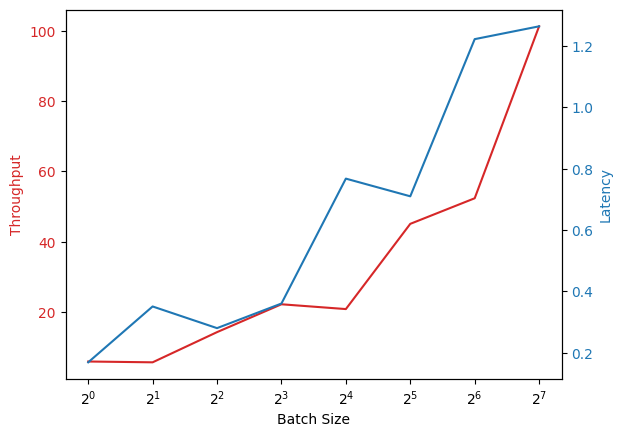

In [ ]:
def render_plot(x, y1, y2, x_label, y1_label, y2_label):
    # Create a figure and a set of subplots
    fig, ax1 = plt.subplots()

    # Plot the first line (throughput)
    color = 'tab:red'
    ax1.set_xlabel(x_label)
    ax1.set_ylabel(y1_label, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Set the x-axis to be log-scaled
    ax1.set_xscale('log', base=2)

    # Instantiate a second axes that shares the same x-axis
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(y2_label, color=color)  # we already handled the x-label with ax1
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()


### plot the throughput vs latency by increasing the batch size
render_plot(
    batch_sizes,
    throughputs,
    latencies,
    "Batch Size",
    "Throughput",
    "Latency"
)

# Continuous Batching
High throughput and low latency solution to solve the trade-off between these two metrics

In [ ]:
# Import all needed functions from Lesson 1 and 2

import helpers
from helpers import init_batch, generate_next_token
from helpers import merge_batches, filter_batch

import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

In [ ]:
model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

# multiple prompts of varying lengths to send to the model at once
prompts = [
    "The quick brown fox jumped over the",
    "The rain in Spain falls",
    "What comes up must",
]

# note: padding=True ensures the padding token will be inserted into the tokenized tensors
inputs = tokenizer(prompts, padding=True, return_tensors="pt")

In [ ]:
def generate_batch_tokens_with_past(inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_batch(inputs, max_tokens):
    # create a list of tokens for every input in the batch
    generated_tokens = [[] for _ in range(inputs["input_ids"].shape[0])]

    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)

    next_inputs = {
        "position_ids": position_ids,
        **inputs
    }
    for _ in range(max_tokens):
        next_token_ids, past_key_values = generate_batch_tokens_with_past(next_inputs)
        next_inputs = {
            "input_ids": next_token_ids.reshape((-1, 1)),  # '-1' here means the remaining elements for this dim
            "position_ids": next_inputs["position_ids"][:, -1].unsqueeze(-1) + 1,  # increment last, discard the rest
            "attention_mask": torch.cat([
                next_inputs["attention_mask"],
                torch.ones((next_token_ids.shape[0], 1)),  # concatenate vector of 1's with shape [batch_size]
            ], dim=1),
            "past_key_values": past_key_values,
        }

        next_tokens = tokenizer.batch_decode(next_token_ids)
        for i, token in enumerate(next_tokens):
            generated_tokens[i].append(token)
    return ["".join(tokens) for tokens in generated_tokens]

In [ ]:
# seed the random number generator so our results are deterministic
random.seed(42)

# constants
queue_size = 32
batch_size = 8

# requests waiting to be processed
# requests are tuples (prompt, max_tokens)
request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

In [ ]:
batches = [
    request_queue[i:i + batch_size]
    for i in range(0, len(request_queue), batch_size)
]

print(len(batches))
batches[0]

4


[('The quick brown fox jumped over the', 100),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10),
 ('The quick brown fox jumped over the', 10)]

regular batching

In [ ]:
# generate tokens for all batches and record duration
t0 = time.time()
with tqdm(total=len(batches), desc=f"bs={batch_size}") as pbar:
    for i, batch in enumerate(batches):
        # to accommodate all the requests with our
        # current implementation, we take the max of
        # all the tokens to generate among the requests
        batch_max_tokens = [b[1] for b in batch]
        max_tokens = max(batch_max_tokens)
        pbar.set_postfix({'max_tokens': max_tokens})

        batch_prompts = [b[0] for b in batch]
        inputs = tokenizer(
            batch_prompts, padding=True, return_tensors="pt")
        generate_batch(inputs, max_tokens=max_tokens)

        pbar.update(1)

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 4/4 [01:27<00:00, 21.93s/it, max_tokens=100]

duration 87.74055886268616


continuous batching

rebatching the whole process in each time-step, instead of only at the begining. Either a new request might comes or one request in the batch has been done, we should recompute the batch structure, and apply this dynamic change and check the state of the batch at each step of calling the model.

In [ ]:
random.seed(42)


queue_size = 32
batch_size = 8


request_queue = [
    (prompts[0], 100 if i % batch_size == 0 else 10)
    for i in range(queue_size)
]

t0 = time.time()
with tqdm(total=len(request_queue), desc=f"bs={batch_size}") as pbar:

    batch = init_batch(request_queue[:batch_size])
    cached_batch = generate_next_token(batch)
    request_queue = request_queue[batch_size:]


    while (
        len(request_queue) > 0 or
        cached_batch["input_ids"].size(0) > 0
    ):
        batch_capacity = (
            batch_size - cached_batch["input_ids"].size(0)
        )
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(request_queue[:batch_capacity])
            new_batch = generate_next_token(new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices = filter_batch(cached_batch)
        pbar.update(len(removed_indices))

duration_s = time.time() - t0
print("duration", duration_s)

bs=8: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]

duration 30.67006516456604


# Quantization

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Model
from utils import generate

model_name = "./models/gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [ ]:
# fix dtype post quantization to "pretend" to be fp32
def get_float32_dtype(self):
    return torch.float32
GPT2Model.dtype = property(get_float32_dtype)

model.get_memory_footprint()

510342192

zero-point quantization

In [ ]:
def quantize(t):
    min_val, max_val = t.min(), t.max()

    scale = (max_val - min_val) / 255
    zero_point = min_val

    t_quant = (t - zero_point) / scale
    t_quant = torch.clamp(t_quant, min=0, max=255)

    # keep track of scale and zero_point for reversing quantization
    ##### the metadata values needed to restore the actual values in the network
    ##### by saving this, we can reconstruct the actual weights without needing to
    ##### save them precisely. However, there is a loss, associated with this functionality
    ##### as we reduce the mem size, we can not precisely recover the actual values we had at first step
    ##### So, this is not a lossless function, it is applicable due to its minimal loss.
    state = (scale, zero_point)

    # cast to uint8 and return
    t_quant = t_quant.type(torch.uint8)
    return t_quant, state

In [ ]:
t = model.transformer.h[0].attn.c_attn.weight.data
print(t, t.shape)

tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]]) torch.Size([768, 2304])


In [ ]:
t_q, state = quantize(t)
print(t_q, t_q.min(), t_q.max())

tensor([[107, 116, 124,  ..., 130, 125, 129],
        [132, 135, 139,  ..., 126, 128, 127],
        [128, 131, 145,  ..., 133, 130, 127],
        ...,
        [116, 127, 137,  ..., 129, 126, 130],
        [135, 138, 133,  ..., 129, 126, 126],
        [110, 119, 117,  ..., 128, 128, 129]], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


zero-point dequantization

In [ ]:
def dequantize(t, state):
    scale, zero_point = state
    return t.to(torch.float32) * scale + zero_point

In [ ]:
t_rev = dequantize(t_q, state)
print(t_rev)

tensor([[-0.4774, -0.2783, -0.1014,  ...,  0.0313, -0.0793,  0.0092],
        [ 0.0755,  0.1419,  0.2303,  ..., -0.0572, -0.0129, -0.0351],
        [-0.0129,  0.0534,  0.3630,  ...,  0.0976,  0.0313, -0.0351],
        ...,
        [-0.2783, -0.0351,  0.1861,  ...,  0.0092, -0.0572,  0.0313],
        [ 0.1419,  0.2082,  0.0976,  ...,  0.0092, -0.0572, -0.0572],
        [-0.4110, -0.2120, -0.2562,  ..., -0.0129, -0.0129,  0.0092]])


In [ ]:
### the loss information after quant and dequant a given input value
torch.abs(t - t_rev)

tensor([[0.0035, 0.0170, 0.0036,  ..., 0.0200, 0.0209, 0.0158],
        [0.0119, 0.0055, 0.0084,  ..., 0.0046, 0.0017, 0.0195],
        [0.0168, 0.0161, 0.0038,  ..., 0.0167, 0.0050, 0.0032],
        ...,
        [0.0191, 0.0187, 0.0131,  ..., 0.0004, 0.0056, 0.0006],
        [0.0098, 0.0088, 0.0067,  ..., 0.0202, 0.0143, 0.0097],
        [0.0010, 0.0196, 0.0162,  ..., 0.0084, 0.0199, 0.0107]])

### model without quantization

In [ ]:
### check the model output without quantization

response_expected = generate(
    model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence and ran to the other side of the fence'

### model with quantization

In [ ]:
def quantize_model(model):
    states = {}
    for name, param in model.named_parameters():
        param.requires_grad = False
        param.data, state = quantize(param.data)
        states[name] = state
    return model, states

In [ ]:
quant_model, states = quantize_model(model)
quant_model.get_memory_footprint()

137022768

In [ ]:
def size_in_bytes(t):
    return t.numel() * t.element_size()


sum([
    size_in_bytes(v[0]) + size_in_bytes(v[1])
    for v in states.values()
])

1184

In [ ]:
def dequantize_model(model, states):
    for name, param in model.named_parameters():
        state = states[name]
        param.data = dequantize(param.data, state)
    return model

In [ ]:
dequant_model = dequantize_model(quant_model, states)
dequant_model.get_memory_footprint()

510342192

In [ ]:
response_expected = generate(
    dequant_model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence.\n\nThe fox jumped over the fence'

# LORA

### abstract

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [ ]:
# set the seed so we get the same results from here on for each run
torch.manual_seed(420)

In [ ]:
class TestModel(torch.nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        self.embedding = torch.nn.Embedding(10, hidden_size)
        self.linear = torch.nn.Linear(hidden_size, hidden_size)
        self.lm_head = torch.nn.Linear(hidden_size, 10)

    def forward(self, input_ids):
        x = self.embedding(input_ids)
        x = self.linear(x)
        x = self.lm_head(x)
        return x

In [ ]:
hidden_size = 1024
model = TestModel(hidden_size)
# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

In [ ]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [ ]:
# generate one token
next_token = generate_token(model, input_ids=input_ids)[0]
next_token

'green'

In [ ]:
X = torch.randn(1, 8, 1024)

In [ ]:
# LoRA A and B tensors
# A has shape (hidden_size, rank)
# B has shape (rank, hidden_size)
### Rank 2 decomposition of the original weight matrix

lora_a = torch.randn(1024, 2)
lora_b = torch.randn(2, 1024)

In [ ]:
W = model.linear.weight
W.shape

torch.Size([1024, 1024])

In [ ]:
W2 = lora_a @ lora_b
W2.shape

torch.Size([1024, 1024])

In [ ]:
# Compare number of elements of A and B with number of elements of W
# W here has shape (hidden_size, hidden_size)
lora_numel = lora_a.numel() + lora_b.numel()
base_numel = W.numel()
print("|A+B| / |W|:", lora_numel / base_numel)

|A+B| / |W|: 0.00390625


In [ ]:
base_output = model.linear(X)

lora_output = X @ lora_a @ lora_b

total_output = base_output + lora_output

total_output.shape

torch.Size([1, 8, 1024])

In [ ]:
class LoraLayer(torch.nn.Module):
    def __init__(self, base_layer, r):
        super().__init__()
        self.base_layer = base_layer

        d_in, d_out = self.base_layer.weight.shape
        self.lora_a = torch.randn(d_in, r)
        self.lora_b = torch.randn(r, d_out)

    def forward(self, x):
        y1 = self.base_layer(x)
        y2 = x @ self.lora_a @ self.lora_b
        return y1 + y2

In [ ]:
# wrap the linear layer of our toy model, use rank 2
lora_layer = LoraLayer(model.linear, 2)
lora_layer(X).shape

torch.Size([1, 8, 1024])

In [ ]:
model.linear = lora_layer
model

TestModel(
  (embedding): Embedding(10, 1024)
  (linear): LoraLayer(
    (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (lm_head): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:
next_token = generate_token(model, input_ids=input_ids)
next_token[0]

'chartreuse'

### Multi-lora Inference

In [ ]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm

torch.manual_seed(42)

In [ ]:
class AbstractMultiLoraModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding = torch.nn.Embedding(10, 10)
        self.linear = torch.nn.Linear(10, 10)
        self.lm_head = torch.nn.Linear(10, 10)

    def linear_lora(
        self,
        x: torch.Tensor,
        loras_a: torch.Tensor,
        loras_b: torch.Tensor,
        lora_indices: torch.LongTensor,
    ) -> torch.Tensor:
        raise NotImplementedError()

    def forward(self, input_ids, loras_a, loras_b, lora_indices):
        x = self.embedding(input_ids)
        x = self.linear_lora(x, loras_a, loras_b, lora_indices)
        x = self.lm_head(x)
        return x

In [ ]:
class LoopMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,
        loras_a: torch.Tensor,
        loras_b: torch.Tensor,
        lora_indices: torch.LongTensor,
    ) -> torch.Tensor:
        y = self.linear(x)
        for batch_idx, lora_idx in enumerate(lora_indices.numpy()):
            lora_a = loras_a[lora_idx]
            lora_b = loras_b[lora_idx]
            y[batch_idx] += x[batch_idx] @ lora_a @ lora_b
        return y

In [ ]:
# toy example of a detokenizer. The vocabular only consists of 10 words (different colors)
detokenizer = [
    "red",
    "orange",
    "yellow",
    "green",
    "blue",
    "indigo",
    "violet",
    "magenta",
    "marigold",
    "chartreuse",
]

# dummy inputs
input_ids = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7]])

In [ ]:
def generate_token(model, **kwargs):
    with torch.no_grad():
        logits = model(**kwargs)
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)

    return [detokenizer[token_id] for token_id in next_token_ids]

In [ ]:
model = LoopMultiLoraModel()

In [ ]:
# constants
bs = 1
num_loras = 64
h = 10
r = 2

# create contiguous blocks for 64 random LoRA weights
loras_a = torch.randn(num_loras, h, r)
loras_b = torch.randn(num_loras, r, h)

for i in range(10):
    # randomize the LoRAs each iteration
    lora_indices = torch.randint(num_loras, (bs,), dtype=torch.long)
    next_token = generate_token(
        model,
        input_ids=input_ids,
        loras_a=loras_a,
        loras_b=loras_b,
        lora_indices=lora_indices,
    )
    print(next_token)

['orange']
['red']
['chartreuse']
['yellow']
['marigold']
['yellow']
['red']
['orange']
['violet']
['red']


In [ ]:
# constants
seq_len = 8
vocab_size = 10
nsamples = 500
max_batch_size = 64


def benchmark(model):
    avg_latencies = []
    for bs in range(1, max_batch_size + 1):
        latencies = []
        for _ in range(nsamples):
            # randomize the inputs and LoRA indices
            input_ids = torch.randint(
                vocab_size, (bs, seq_len), dtype=torch.long)
            lora_indices = torch.randint(
                num_loras, (bs,), dtype=torch.long)

            # measure the end-to-end latency for
            # generating a single token
            t0 = time.time()
            next_token = generate_token(
                model,
                input_ids=input_ids,
                loras_a=loras_a,
                loras_b=loras_b,
                lora_indices=lora_indices,
            )
            latencies.append(time.time() - t0)

        # average the latency across all the samples
        latency_s = sum(latencies) / len(latencies)
        avg_latencies.append(latency_s)
        print(bs, latency_s)
    return avg_latencies

In [ ]:
avg_latencies_loop = benchmark(model)

1 0.00021678686141967773
2 0.00024003410339355468
3 0.0002725133895874023
4 0.00042358064651489257
5 0.00031502485275268553
6 0.0004191336631774902
7 0.0003922147750854492
8 0.0004370250701904297
9 0.00047461605072021484
10 0.0005261802673339844
11 0.0005296783447265625
12 0.0005620980262756348
13 0.0006085147857666015
14 0.0006518445014953614
15 0.0006629586219787598
16 0.0006757950782775878
17 0.0007572860717773438
18 0.0007540459632873535
19 0.000802126407623291
20 0.0010482187271118164
21 0.001225450038909912
22 0.0012458662986755372
23 0.0013733744621276856
24 0.00150626802444458
25 0.0009633951187133789
26 0.0010240511894226074
27 0.001011772632598877
28 0.001072767734527588
29 0.001071216583251953
30 0.001135688304901123
31 0.0011258220672607422
32 0.0011971354484558105
33 0.0012385964393615723
34 0.0012316365242004395
35 0.0012910032272338866
36 0.00133705472946167
37 0.0013331913948059083
38 0.0013782801628112794
39 0.0014170465469360352
40 0.0014165501594543457
41 0.002073769

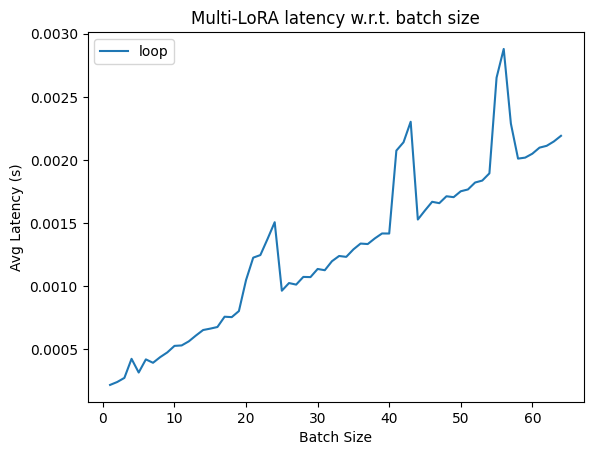

In [ ]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

In [ ]:
class GatheredMultiLoraModel(AbstractMultiLoraModel):
    def linear_lora(
        self,
        x: torch.Tensor,                 # (batch_size, seq_len, in_features)
        loras_a: torch.Tensor,           # (num_loras, in_features, lora_rank)
        loras_b: torch.Tensor,           # (num_loras, lora_rank, out_features)
        lora_indices: torch.LongTensor,  # (batch_size,)
    ) -> torch.Tensor:
        y = self.linear(x)

        # gather the LoRA weights into a new tensor and apply
        lora_a = torch.index_select(loras_a, 0, lora_indices) # (batch_size, in_features, lora_rank)
        lora_b = torch.index_select(loras_b, 0, lora_indices) # (batch_size, lora_rank, out_features)
        y += x @ lora_a @ lora_b
        return y

In [ ]:
model = GatheredMultiLoraModel()
avg_latencies_gathered = benchmark(model)

1 0.00020810461044311524
2 0.00018020963668823243
3 0.0001937398910522461
4 0.0001873788833618164
5 0.000210357666015625
6 0.0002004714012145996
7 0.00020259904861450194
8 0.00021492528915405273
9 0.000256688117980957
10 0.00020877933502197265
11 0.00032984542846679687
12 0.0003476142883300781
13 0.00037488889694213865
14 0.0003422675132751465
15 0.00040418195724487303
16 0.00033667469024658203
17 0.00035413646697998047
18 0.0003322858810424805
19 0.00034740877151489256
20 0.000451387882232666
21 0.00041964197158813476
22 0.00046405935287475585
23 0.0004584336280822754
24 0.0004904546737670898
25 0.00045606231689453126
26 0.00027251672744750977
27 0.00028014373779296876
28 0.000265775203704834
29 0.00030847120285034177
30 0.00027746200561523437
31 0.00031378650665283203
32 0.00028711843490600585
33 0.000303408145904541
34 0.0003040909767150879
35 0.00031937408447265623
36 0.000294189453125
37 0.0003358278274536133
38 0.00030279254913330076
39 0.00032738208770751956
40 0.000318273067474

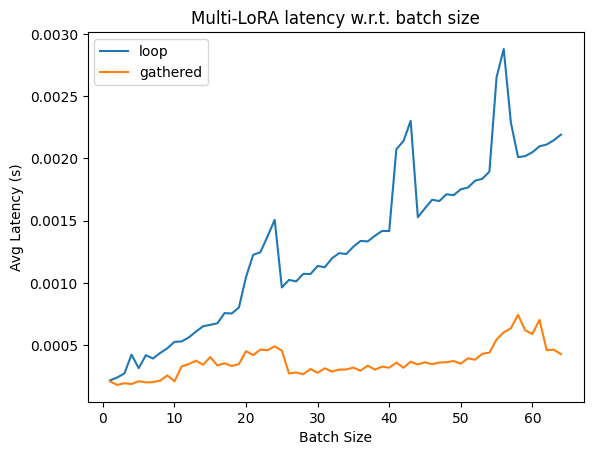

In [ ]:
x = list(range(1, max_batch_size + 1))
plt.plot(x, avg_latencies_loop, label="loop")
plt.plot(x, avg_latencies_gathered, label="gathered")

plt.xlabel('Batch Size')
plt.ylabel('Avg Latency (s)')
plt.title('Multi-LoRA latency w.r.t. batch size')
plt.legend()

plt.show()

### using vectorization, make the multi-lora fine-tuning faster w.r.t the batch size